In [30]:
import math
import numpy as np
import statsmodels.stats.power as smp
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd


plt.style.use('ggplot')

### Бутстреп

Пусть мы хотим оценить 90% квантиль. Мы можем это сделать по данным, но как оценить стандартное отклонение полученной оценки? Простой универсальной теоретической формулы для оценки стандартного отклонения квантиля нет.

Было бы хорошо, если у нас было 100 параллельных вселенных. Мы бы в каждой вселенной собрали данные, посчитали 100 квантилей и оценили стандартное отклонения по полученным значениям. Но у нас нет 100 параллельных вселенных.



Используем бутстрап.
Для этого 1000 раз сгенерируем подвыборки из ЭФР, вычислим значение статистики в каждой подвыборке и оценим стандартное отклонение получившихся значений.

In [31]:
n = 1000            # размер исходной выборки
B = 1000            # количество генерируемых подвыборок

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)
print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 115.35
Оценка std для 90% квантиля: 0.94


### Обратим внимание на два момента:

1) Чтобы оценка стандартного отклонения была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;

2) Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

### ДИ с помощью бутстрепа

1. Нормальный ДИ (pe - point estimation, точечная оценка по выборке)

2. Персентильный бутстреп (отсекаем просто по квантилям хвосты)

3. Центральный ДИ

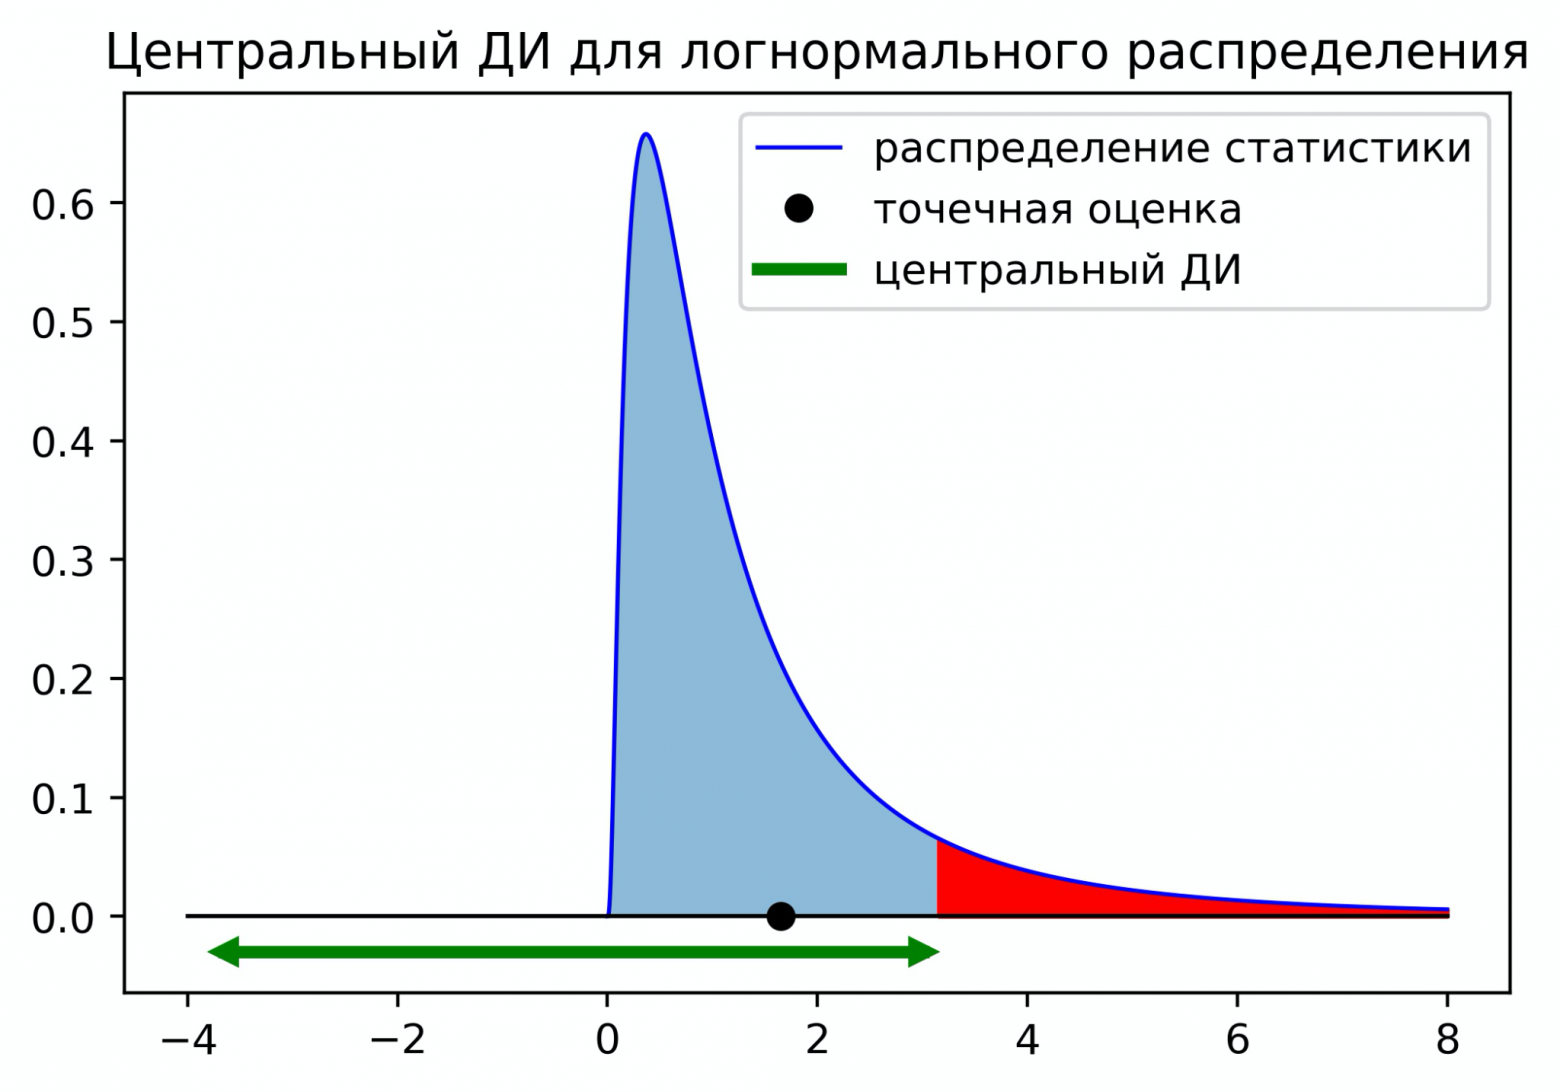

Центральный ДИ для логнормального распределения смещён в сторону с нулевой плотностью. Это можно интерпретировать как стремление перестраховаться на случай, если у нас неполная информация о распределении, и левее нуля на самом деле могут быть значения.



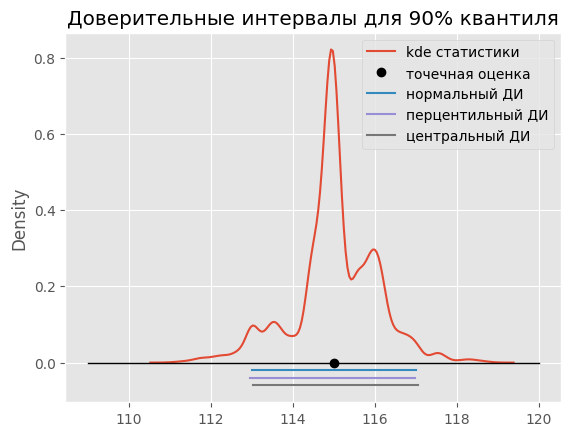

In [33]:
import seaborn as sns

def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал."""
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Строит центральный доверительный интервал."""
    left, right= 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

n = 1000
B = 10000
alpha = 0.05

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = np.quantile(np.random.choice(values, (B, n), True), 0.9, axis=1)

normal_ci = get_normal_ci(bootstrap_quantiles, quantile, alpha)
percentile_ci = get_percentile_ci(bootstrap_quantiles, quantile, alpha)
pivotal_ci = get_pivotal_ci(bootstrap_quantiles, quantile, alpha)

sns.kdeplot(bootstrap_quantiles, label='kde статистики')
plt.plot([quantile], [0], 'o', c='k', markersize=6, label='точечная оценка')
plt.plot([109, 120], [0, 0], 'k', linewidth=1)
d = 0.02
plt.plot(normal_ci, [-d, -d], label='нормальный ДИ')
plt.plot(percentile_ci, [-d*2, -d*2], label='перцентильный ДИ')
plt.plot(pivotal_ci, [-d*3, -d*3], label='центральный ДИ')

plt.title('Доверительные интервалы для 90% квантиля')
plt.legend()
plt.show()

## Проверка гипотез с помощью бутстрепа

Чтобы проверить гипотезу о равенстве квантилей на уровне значимости 5% достаточно построить 95% доверительный интервал для разности квантилей между группами.

Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет.

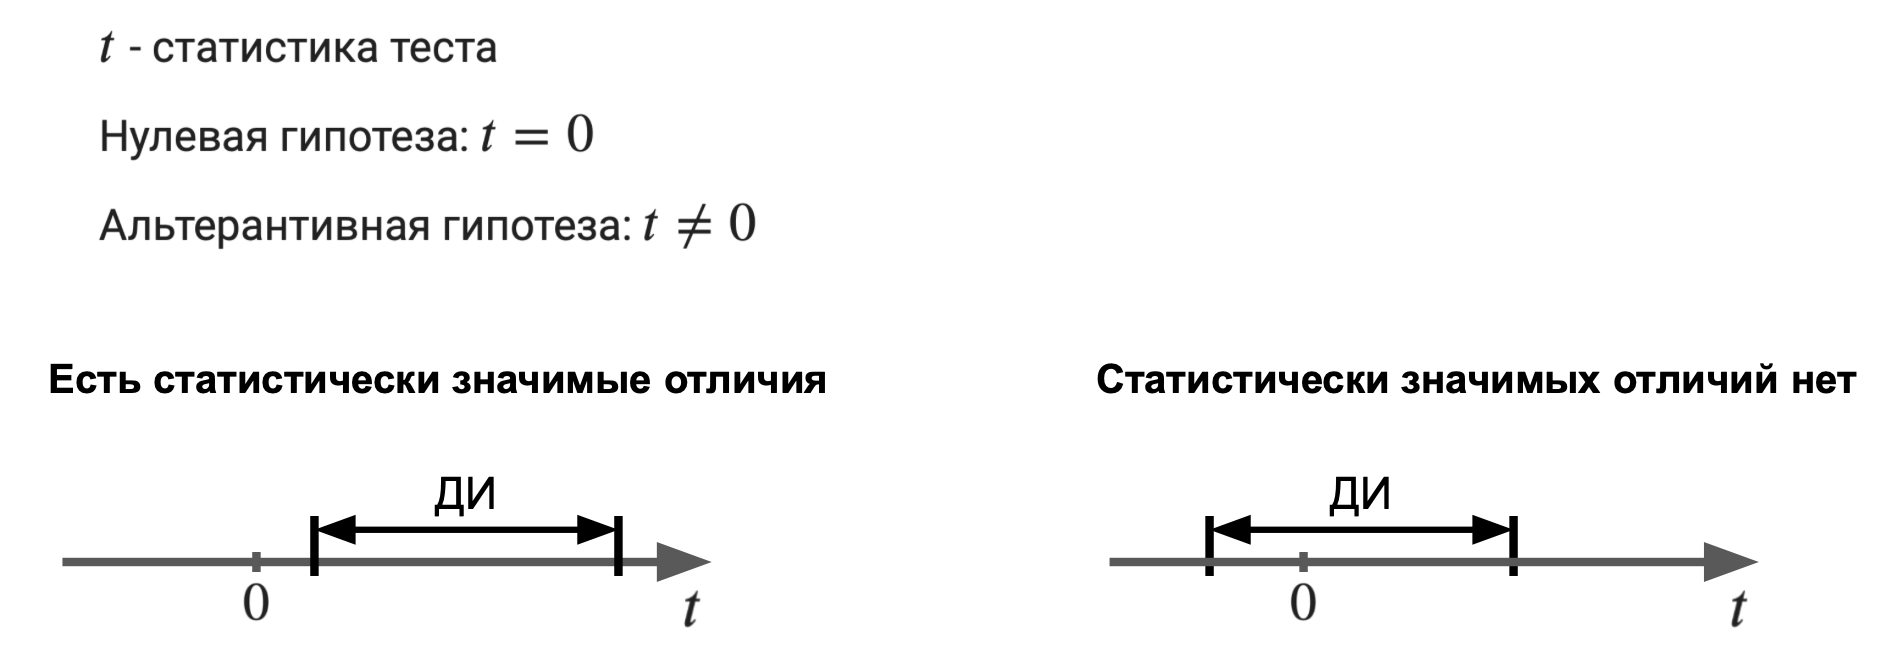

Опишем ещё раз алгоритм проверки гипотез о равенстве двух произвольных метрик с помощью бутстрепа:

1. Генерируем пару подвыборок того же размера из исходных данных контрольной и экспериментальной групп;

2. Считаем метрики (реализация оценки метрики) для каждой из групп;

3. Вычисляем разность метрик, сохраняем полученное значение;

4. Повторяем шаги 1-3 от 1000 до 10000 раз;

5. Строим доверительный интервал с уровнем значимости \alpha;

6. Если 0 не принадлежит ДИ, то отличия статистически значимы на уровне значимости \alpha, иначе нет. 

In [34]:
n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(90, 20, n) # среднее 90, дисперсия 20
values_b = np.random.normal(90, 15, n) # среднее 90, дисперсия 15

pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9)
bootstrap_values_a = np.random.choice(values_a, (B, n), True) # сгенерируем n примеров размера B (матрицу Bxn).
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.9, axis=1) # посчитаем квантиль. Получим n квантилей
bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.9, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'Значение 90% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 90% квантиля изменилось на: -6.71
95.0% доверительный интервал: (-8.93, -3.72)
Отличия статистически значимые: True
